<a href="https://colab.research.google.com/github/rajeshmore1/Anomaly-Detection-By-using-keras/blob/main/Anomaly_Detection_By_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


#Task 2: Load and Inspect the S&P 500 Index Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/8 may self learn/S&P_500_Index_Data.csv", parse_dates = ["date"])

In [4]:
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
df.shape

(8192, 2)

In [9]:
# Line chart using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

# Task3: Data Pre-Processing

In [10]:
# Splitting data into 80% Vs 20%
train_size = int(len(df)*0.8)
test_size = len(df)-train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

# Task4: Create training and test split

In [13]:
def create_sequence(X,y, time_steps =1):
  Xs,ys =[],[]
  for i in range(len(X)-time_steps):
    Xs.append(X.iloc[i:(i+time_steps)].values)
    ys.append(y.iloc[i+ time_steps])
  return np.array(Xs),np.array(ys)

In [14]:
time_steps = 30
X_train , y_train = create_sequence(train[['close']], train.close, time_steps)
X_test , y_test = create_sequence(test[['close']], test.close, time_steps)

In [15]:
X_train.shape

(6523, 30, 1)

# Task 5 : Build and Autoencoder

In [16]:
time_steps = X_train.shape[1]
num_features = X_train.shape[2]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
                    LSTM(128, input_shape=(time_steps, num_features)),
                    Dropout(0.2),
                    RepeatVector(time_steps),
                    LSTM(128, return_sequences = True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))

])

model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

# Task6: Train The Autoencoder

In [18]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.1,
    callbacks= [es],
    shuffle= False
)

Epoch 1/100
184/184 [==============================] - 17s 74ms/step - loss: 0.2801 - val_loss: 0.1742
Epoch 2/100
184/184 [==============================] - 13s 69ms/step - loss: 0.1803 - val_loss: 0.0572
Epoch 3/100
184/184 [==============================] - 13s 69ms/step - loss: 0.1257 - val_loss: 0.0524
Epoch 4/100
184/184 [==============================] - 13s 70ms/step - loss: 0.1139 - val_loss: 0.0530
Epoch 5/100
184/184 [==============================] - 13s 70ms/step - loss: 0.1064 - val_loss: 0.0427
Epoch 6/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1092 - val_loss: 0.0486
Epoch 7/100
184/184 [==============================] - 13s 70ms/step - loss: 0.1155 - val_loss: 0.0768
Epoch 8/100
184/184 [==============================] - 13s 70ms/step - loss: 0.1119 - val_loss: 0.0380
Epoch 9/100
184/184 [==============================] - 13s 70ms/step - loss: 0.1071 - val_loss: 0.0283
Epoch 10/100
184/184 [==============================] - 13s 70ms/step - l

#Task7: Plot Metrics and Evaluate the model

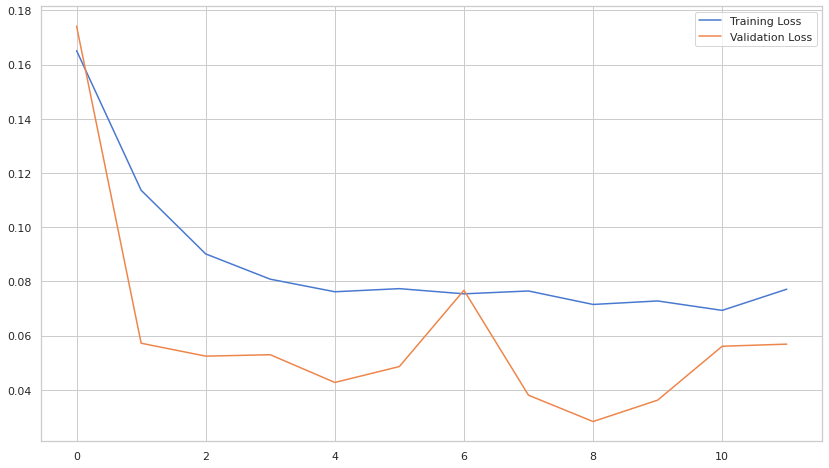

In [19]:
plt.plot(history.history['loss'], label= 'Training Loss'),
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend();

In [21]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [22]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 21ms/step - loss: 0.3637


0.3636506497859955

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



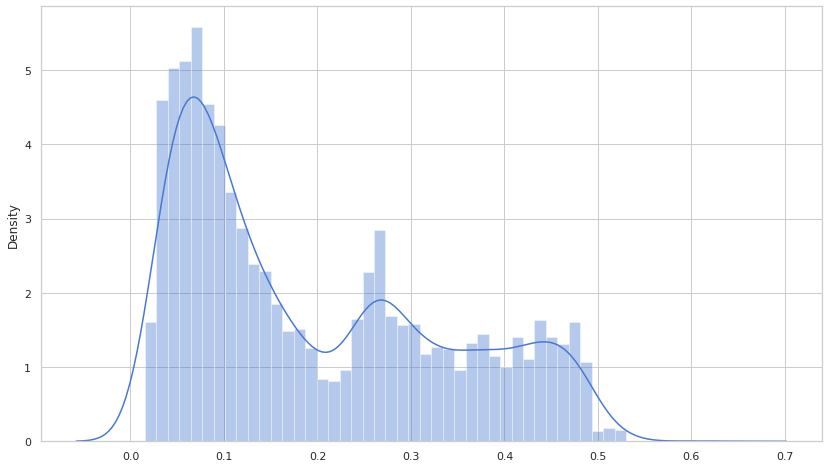

In [24]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [25]:
threshold = 0.65

In [26]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Task 8: Detect Anomalies in the S&P index data

In [28]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss']= test_mae_loss
test_score_df['threshold']= threshold
test_score_df['anomaly']=test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [29]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.056087,0.65,False
6584,2012-02-09,1.221625,0.056091,0.65,False
6585,2012-02-10,1.199313,0.055967,0.65,False
6586,2012-02-13,1.221194,0.055956,0.65,False
6587,2012-02-14,1.218150,0.054454,0.65,False


In [30]:
test_score_df.shape

(1609, 5)

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.loss,
                         mode='lines',name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                         mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [33]:
anomalies = test_score_df[test_score_df.anomaly==True]
anomalies

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.721399,0.65,True
7475,2015-08-26,2.632149,0.789023,0.65,True
7476,2015-08-27,2.745147,0.697441,0.65,True
8090,2018-02-05,4.329949,0.729003,0.65,True
8091,2018-02-06,4.440671,0.899477,0.65,True
...,...,...,...,...,...
8187,2018-06-25,4.493228,0.728039,0.65,True
8188,2018-06-26,4.507583,0.773667,0.65,True
8189,2018-06-27,4.451431,0.783855,0.65,True
8190,2018-06-28,4.491406,0.813501,0.65,True


In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),
                         mode='lines',name='Close price'))
fig.add_trace(go.Scatter(x= anomalies.date, y=scaler.inverse_transform(anomalies.close),
                         mode='lines', name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()